In [1]:
#Generate plot 3 showing the efect of moments on the temp distribution.

In [44]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import dask
#import daskdataframe as dd
import matplotlib.pyplot as plt
import matplotlib as mtplt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
#import xskillscore as xs
import cartopy as cart
#%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.special import erfinv, erf
##mtplt.use("TkCairo")
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [3]:
def get_data_array(filename, recalculate=False):
    """
    Fetches an xarray data array from a zarr file. Recalculates if the file doesn't exist or if recalculate is True.

    Parameters:
    -----------
    filename: str
        The path to the zarr file.
    recalculate: bool
        If True, recalculate the data array. If False (default), load the data array from the file if it exists.

    Returns:
    --------
    xr.DataArray
        The data array.
    """

    if recalculate or not zarr.is_zarr(filename):
        # Recalculate the data array
        # TODO: replace this with your own code to calculate the data array
        data_array = xr.DataArray([[1, 2], [3, 4]], dims=('x', 'y'))
        
        # Save the data array to the zarr file
        data_array.to_dataset(name='data_array').to_zarr(filename)
    else:
        # Load the data array from the zarr file
        data_array = xr.open_zarr(filename)['data_array']

    return data_array

In [4]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [5]:
def stacker(x,stackdim_name):
    #Assumes that x has dimensions year and member
    #x = x.stack(stackdim_name=('year','member'),create_index=False)
    x = x.stack({stackdim_name: ('year', 'member')},create_index=False)
    return x

In [6]:
def stack_roll(ds,roll_len,stride_len,stackdim_name):
    #Assumes that ds has dimensions year and member
    ds_stack   = stacker(ds,stackdim_name)
    #print(ds_stack)
    ds_roll    = ds_stack.rolling({stackdim_name:roll_len}, center=True).construct('index', stride=stride_len)
    
    return ds_roll 

In [7]:
def mean_adj(ds_stack,ds_mroll):
    ds = (ds_stack - ds_stack.mean(dim='myear')) + ds_mroll
    return ds

def mean_std_adj(ds_stack,ds_mroll,ds_sroll):
    ds = (ds_stack -ds_stack.mean(dim='myear'))*(ds_sroll/ds_stack.std(dim='myear'))\
          + ds_mroll
    return ds

In [8]:
def gauss_quantile(mean,std,quantile):
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue

In [9]:
# #Chicago
LAT        = 41.8781
LON        = (360-87.6298)%360
# # #Bengaluru:
# LAT        = 12.9716
# LON        = 77.5946
######################
chic_lat  = 41.8781
chic_lon  = (360-87.6298)%360
ben_lat   = 12.9716
ben_lon   = 77.5946
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
savefigs   = '/global/scratch/users/harsha/savefigs/Feb21/'
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
cvals_det  = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
loc        = 'Chicago/'
locn       = 'Chicago'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
###########
print('(lat,lon)=',LAT,LON)

(lat,lon)= 41.8781 272.3702


In [10]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=condo_cumulus_lr6','--account=lr_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=20, walltime='5:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(3)

In [11]:
def altspace(start, step, count, endpoint=False, **kwargs):
   stop = start+(step*count)
   return np.linspace(start, stop, count, endpoint=endpoint, **kwargs)

In [12]:
cluster

In [13]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
pi_year  = 1865
ic_year  = 2071
doy      = 211 # day_of_year
date     = 'Jul30'

In [14]:
#To reduce communication between workers, I am manually fusing tasks
#dask.optimization.fuse(ave_width=50)

In [15]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 845 ms, sys: 135 ms, total: 980 ms
Wall time: 1.31 s


In [16]:
%%time
#t-temp, nw - no-warming, w-warming, hw = historical warming, g=global
tgpi   = ds_hist.TREFHTMX.sel(method='nearest',time=ds_hist.time.dt.dayofyear==doy).\
         sel(time=slice(pi_year0,pi_year1))
tgeoc  = ds_ssp.TREFHTMX.sel(method='nearest',time=ds_ssp.time.dt.dayofyear==doy).\
         sel(time=slice(ic_year0,ic_year1))

CPU times: user 245 ms, sys: 7.74 ms, total: 253 ms
Wall time: 248 ms


In [17]:
tgpi   = tgpi.chunk({'member':100,'lat':40,'lon':60})
tgeoc  = tgeoc.chunk({'member':100,'lat':40,'lon':60})
tdgpi  = to_daily(tgpi).sel(day=doy)
tdgeoc = to_daily(tgeoc).sel(day=doy)

In [18]:
pcoeffs_gpi  = tdgpi.mean('member').polyfit(dim='year',deg=1)
pcoeffs_geoc = tdgeoc.mean('member').polyfit(dim='year',deg=1)
pcoeffs_geoc

<xarray.Dataset>
Dimensions:               (lat: 192, lon: 288, degree: 2)
Coordinates:
  * lat                   (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon                   (lon) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * degree                (degree) int64 1 0
Data variables:
    polyfit_coefficients  (degree, lat, lon) float64 dask.array<chunksize=(2, 8, 288), meta=np.ndarray>

In [19]:
mgpi  = pcoeffs_gpi.polyfit_coefficients.sel(degree=1)
mgeoc = pcoeffs_geoc.polyfit_coefficients.sel(degree=1)

In [20]:
gpi_trend  = mgpi*(tdgpi['year']-pi_year)
geoc_trend = mgeoc*(tdgeoc['year']-ic_year)
geoc_trend

<xarray.DataArray (lat: 192, lon: 288, year: 30)>
dask.array<mul, shape=(192, 288, 30), dtype=float64, chunksize=(8, 288, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    degree   int64 1
  * year     (year) int64 2071 2072 2073 2074 2075 ... 2096 2097 2098 2099 2100
    day      int64 211

In [21]:
tgpi_det  = tdgpi  - gpi_trend
tgeoc_det = tdgeoc - geoc_trend
tgpi_det

,Array,Chunk
Bytes,1.24 GiB,3.66 MiB
Shape,"(192, 288, 100, 30)","(8, 60, 100, 10)"
Count,7063 Tasks,375 Chunks
Type,float64,numpy.ndarray


In [22]:
%%time
#Stack member and year into one dimension- 'ym'. Then, roll over this dimension with stride = N_mem.
#This works because of the way xarray stacks two dimensions. window_len =30. 
#I have called the 'window' dimension 'index'.
quants  = np.arange(0,1.01,0.01)
########################
N_mem       = 100 
window_len  = 30
#### July 30 #######
tgpi_detroll     = stack_roll(tgpi_det,N_mem*window_len,N_mem,stackdim_name='ym')
tgeoc_detroll    = stack_roll(tgeoc_det,N_mem*window_len,N_mem,stackdim_name='ym')
#########
tgpi_detroll0    = tgpi_detroll.sel(ym=[15])  
tgeoc_detroll0   = tgeoc_detroll.sel(ym=[15])  
tgeoc_detroll0

CPU times: user 43.3 ms, sys: 1.14 ms, total: 44.5 ms
Wall time: 42.5 ms


,Array,Chunk
Bytes,1.24 GiB,10.99 MiB
Shape,"(192, 288, 1, 3000)","(8, 60, 1, 3000)"
Count,10166 Tasks,125 Chunks
Type,float64,numpy.ndarray


In [23]:
%%time
############# Save files ########################
tgeoc_detrollpath  = cvals_det + 'tgeoc_detrended_roll' +date+'_'+pi_year0+'_'+pi_year1+'.zarr'
# Save eoc detrended rolled array
tgeoc_detroll0     =  tgeoc_detroll0.rename('eoc_detrended_roll')\
                  .chunk({'lat':8}).assign_coords(ym=('ym',[2086]))
# tgeoc_detroll0.to_dataset().to_zarr(tgeoc_detrollpath,mode='w')

CPU times: user 6.02 ms, sys: 0 ns, total: 6.02 ms
Wall time: 5.79 ms


In [24]:
%%time
#Compute the pre-industrial + moments adjusted curves
#First compute rolling means and stdevs and save them
#Open
tgeoc_detroll   = xr.open_zarr(tgeoc_detrollpath).eoc_detrended_roll
tgeoc_det_mroll = tgeoc_detroll.mean(dim='index')
tgeoc_det_sroll = tgeoc_detroll.std(dim='index')
#############
tgeoc_det_mroll

CPU times: user 19.2 ms, sys: 131 µs, total: 19.3 ms
Wall time: 22.2 ms


<xarray.DataArray 'eoc_detrended_roll' (lat: 192, lon: 288, ym: 1)>
dask.array<mean_agg-aggregate, shape=(192, 288, 1), dtype=float64, chunksize=(8, 60, 1), chunktype=numpy.ndarray>
Coordinates:
    day      int64 ...
    degree   int64 ...
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    year     (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * ym       (ym) int64 2086

In [25]:
#Now prepare the pre-industrial data array in order to apply the moment delta mapping transformations
###Add a dummy dimension called 'ym' to tgpi_detrended after stacking year and member as 'myear'
############ det ###########
tgpi_det_stack = stacker(tgpi_det,'myear')
###################################
tgpi_det_stack0= tgpi_det_stack.expand_dims(dim={'ym':1}).\
                 assign_coords(ym=('ym',[2086]))
tgpi_det_stack0

,Array,Chunk
Bytes,1.24 GiB,3.66 MiB
Shape,"(1, 192, 288, 3000)","(1, 8, 60, 1000)"
Count,8188 Tasks,375 Chunks
Type,float64,numpy.ndarray


In [26]:
%%time
#############
tgmc_det  = mean_adj(tgpi_det_stack0, tgeoc_det_mroll)
tgmsc_det = mean_std_adj(tgpi_det_stack0, tgeoc_det_mroll,tgeoc_det_sroll)
tgmc_det

CPU times: user 2.28 s, sys: 321 ms, total: 2.6 s
Wall time: 23.3 s


,Array,Chunk
Bytes,1.24 GiB,3.66 MiB
Shape,"(1, 192, 288, 3000)","(1, 8, 60, 1000)"
Count,10949 Tasks,405 Chunks
Type,float64,numpy.ndarray


In [27]:
%%time
#### Compute quantiles 
quants       = np.arange(0,1.01,0.01)
qgmc_det     = tgmc_det.chunk(dict(myear=-1)).quantile(quants,dim='myear',skipna=False)
qgmsc_det    = tgmsc_det.chunk(dict(myear=-1)).quantile(quants,dim='myear',skipna=False)
qgmc_det

CPU times: user 23.8 ms, sys: 97 µs, total: 23.9 ms
Wall time: 22.8 ms


,Array,Chunk
Bytes,42.61 MiB,378.75 kiB
Shape,"(101, 1, 192, 288)","(101, 1, 8, 60)"
Count,11624 Tasks,135 Chunks
Type,float64,numpy.ndarray


In [28]:
%%time
qgmsc_detpath = cvals_det+'qgmsc_percentile_det'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmc_detpath  = cvals_det+'qgmc_percentile_det'+date+'_' +ic_year0+'_'+ic_year1+'.zarr'
##################### Save #####################
qgmc_det       = qgmc_det.rename('qgmc_detrended').chunk({'lat':8})
qgmsc_det      = qgmsc_det.rename('qgmsc_detrended').chunk({'lat':8})
#
# qgmc_det.to_dataset().to_zarr(qgmc_detpath,mode='w') 
# qgmsc_det.to_dataset().to_zarr(qgmsc_detpath,mode='w')

CPU times: user 7.1 ms, sys: 0 ns, total: 7.1 ms
Wall time: 6.74 ms


In [36]:
qgmc_det  = xr.open_zarr(qgmc_detpath).qgmc_detrended
qgmsc_det = xr.open_zarr(qgmsc_detpath).qgmsc_detrended

In [42]:
########## EOC gaussians ###########
tgeoc_det_mroll0 = tgeoc_det_mroll.expand_dims(dim={'quantile':101}).\
               assign_coords(quantile=('quantile',quants))
tgeoc_det_sroll0 = tgeoc_det_sroll.expand_dims(dim={'quantile':101}).\
               assign_coords(quantile=('quantile',quants))
# Create a DataArray for the quantiles
quantiles = xr.DataArray(np.arange(0, 1.01, 0.01), dims='quantile').\
assign_coords(quantile=('quantile',quants))
####### Construct gaussians for model warming ################
qg        = xr.apply_ufunc(erfinv,2*quantiles-1)
#################
qgauss_det      = tgeoc_det_mroll0 + tgeoc_det_sroll0 * np.sqrt(2) *qg
qgauss_det.name = 'gauss_detrended'
qgauss_det

<xarray.DataArray 'gauss_detrended' (quantile: 101, lat: 192, lon: 288, ym: 1)>
dask.array<add, shape=(101, 192, 288, 1), dtype=float64, chunksize=(101, 8, 60, 1), chunktype=numpy.ndarray>
Coordinates:
    day       int64 211
    degree    int64 1
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    year      (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * ym        (ym) int64 2086
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [29]:
qgeoc_det = tgeoc_detroll0.chunk(dict(index=-1)).quantile(quants,dim='index',skipna=False)
qgeoc_det

<xarray.DataArray 'eoc_detrended_roll' (quantile: 101, lat: 192, lon: 288, ym: 1)>
dask.array<transpose, shape=(101, 192, 288, 1), dtype=float64, chunksize=(101, 8, 60, 1), chunktype=numpy.ndarray>
Coordinates:
    year      (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    (ym) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * ym        (ym) int64 2086
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [43]:
%%time
###### Error in prediction for EOC #######
qgmsc_det_err  = qgmsc_det.sel(ym=2086)  - qgeoc_det.sel(ym=2086)
qgmc_det_err   = qgmc_det.sel(ym=2086)   - qgeoc_det.sel(ym=2086)
qgauss_det_err = qgauss_det.sel(ym=2086) - qgeoc_det.sel(ym=2086)
#qgeoc_det_err  = qgeocm_det              - qgmw_det.sel(ym=2086)
qgmsc_det_err 

CPU times: user 204 ms, sys: 11.2 ms, total: 215 ms
Wall time: 586 ms


<xarray.DataArray (quantile: 101, lat: 192, lon: 288)>
dask.array<sub, shape=(101, 192, 288), dtype=float64, chunksize=(101, 8, 60), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
    year      int64 2086
    ym        int64 2086

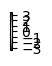

In [49]:
######## New colorbar only for shift + stretch and gaussian ############
x = 3.5
# create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
# Define colormap
cmap = plt.get_cmap('RdBu_r')
# Make a norm object with the center at 0: TwoSlopeNorm
norm = mcolors.TwoSlopeNorm(vmin=-x, vcenter=0, vmax=x)
# Making numpy array from -3 to 3, with step 0.2
values = np.arange(-x, x+0.25, 0.25)
# Creating a mappable object and setting the norm and cmap for colorbar
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
# Creating a colorbar
ticks1 = altspace(-4,1,9)
cbar = plt.colorbar(mappable, ax=ax, orientation='vertical',ticks=ticks1)
cbar.set_label('')
plt.gca().set_visible(False)

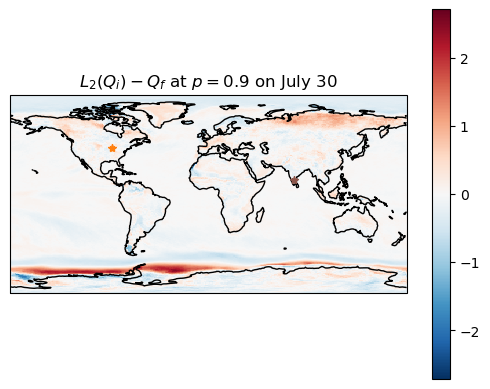

CPU times: user 17.6 s, sys: 820 ms, total: 18.4 s
Wall time: 1min 20s


In [45]:
%%time
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmsc_det_err.sel(quantile=0.9).plot(ax=ax,transform=cart.crs.PlateCarree())
                                      #,add_colorbar=False)
                                     #cbar_kwargs={'ticks': ticks})
ax.coastlines(color="black")
#plt.title('q=0.9,'+r'$\delta t_w - \delta t_{msc}$')
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
plt.xlabel('lon')
plt.ylabel('lat')
plt.title(r'$L_2(Q_i) - Q_f$ at $p=0.9$ on July 30')
plt.show()

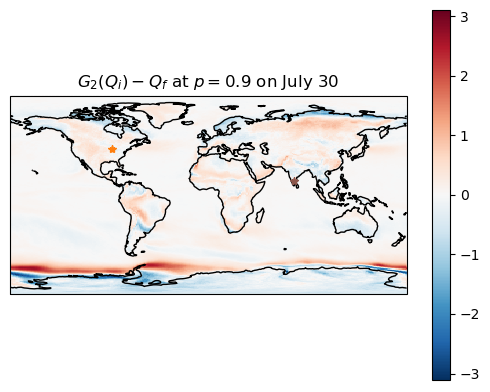

CPU times: user 19.2 s, sys: 830 ms, total: 20 s
Wall time: 1min 20s


In [46]:
%%time
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgauss_det_err.sel(quantile=0.9).plot(ax=ax,transform=cart.crs.PlateCarree())
                                      #,add_colorbar=False)
                                     #cbar_kwargs={'ticks': ticks})
ax.coastlines(color="black")
#plt.title('q=0.9,'+r'$\delta t_w - \delta t_{msc}$')
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
plt.xlabel('lon')
plt.ylabel('lat')
plt.title(r'$G_2(Q_i) - Q_f$ at $p=0.9$ on July 30')
plt.show()

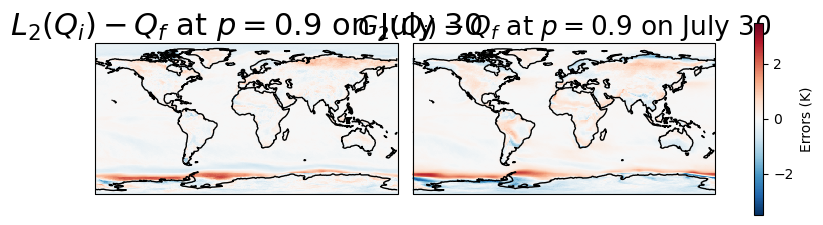

CPU times: user 55 s, sys: 3.18 s, total: 58.2 s
Wall time: 2min 38s


In [52]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), subplot_kw={'projection': cart.crs.PlateCarree()}\
                       , gridspec_kw = {'wspace':0.05, 'hspace':0.2})

# Plotting qgmsc_err
qgmsc_det_err.sel(quantile=0.9).plot(ax=axs[0], transform=cart.crs.PlateCarree(),add_colorbar=False, cmap=cmap, norm=norm)
axs[0].coastlines(color="black")
#axs[0].add_feature(cfeature.BORDERS, linestyle=':')
axs[0].set_title(r'$L_2(Q_i) - Q_f$ at $p=0.9$ on July 30',fontsize=22)

# Plotting da2
im = qgauss_det_err.sel(quantile=0.9).plot(ax=axs[1], transform=cart.crs.PlateCarree(), add_colorbar=False, cmap=cmap, norm=norm)
axs[1].coastlines(color="black")
#axs[1].add_feature(cfeature.BORDERS, linestyle=':')
axs[1].set_title(r'$G_2(Q_i) - Q_f$ at $p=0.9$ on July 30',fontsize=19)

# Adding colorbar
cbar = plt.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5, orientation='vertical')
cbar.set_label('Errors (K)')

#plt.tight_layout()
plt.show()

In [ ]:
################################### Coded until here ############

In [17]:
tgmw_construct_nandrop.sel(lat=LAT,lon=LON,method='nearest').sel(tm=1).values

array([300.32047, 296.2481 , 301.80316, ..., 305.458  , 309.0177 ,
       307.67035], dtype=float32)

In [28]:
# ####### Construct gaussians for model warming ################
# qgauss_mw = xr.apply_ufunc(
#     gauss_quantile,
#     tgmw_mroll0,
#     tgmw_sroll0,
#     quantiles,
#     input_core_dims=[[], [],[]],
#     output_core_dims=[[]],
#     vectorize=True,
#     output_dtypes=[float],
#     #output_sizes={'quantile': 101},
#     dask='parallelized'
# )
# qgauss_mw.name ='TREFHTMX'
# qgauss_mw

In [29]:
####### Construct gaussians for model warming ################
qg  = xr.apply_ufunc(erfinv, 2*quantiles-1)
qg

<xarray.DataArray (quantile: 101)>
array([       -inf, -1.64497636, -1.45221978, -1.32992191, -1.23792199,
       -1.16308715, -1.09939095, -1.04354184, -0.99353563, -0.94805698,
       -0.9061938 , -0.86728635, -0.83084113, -0.79647881, -0.76390113,
       -0.73286908, -0.70318791, -0.67469672, -0.64726086, -0.62076642,
       -0.59511608, -0.57022593, -0.54602306, -0.52244362, -0.49943133,
       -0.47693628, -0.4549139 , -0.43332422, -0.41213118, -0.39130209,
       -0.37080716, -0.35061914, -0.33071299, -0.31106558, -0.29165548,
       -0.27246271, -0.25346864, -0.23465575, -0.21600754, -0.19750838,
       -0.17914345, -0.1608986 , -0.14276025, -0.12471537, -0.10675136,
       -0.08885599, -0.07101736, -0.05322383, -0.03546394, -0.0177264 ,
        0.        ,  0.0177264 ,  0.03546394,  0.05322383,  0.07101736,
        0.08885599,  0.10675136,  0.12471537,  0.14276025,  0.1608986 ,
        0.17914345,  0.19750838,  0.21600754,  0.23465575,  0.25346864,
        0.27246271,  0.29165548,  0.31106558,  0.33071299,  0.35061914,
        0.37080716,  0.39130209,  0.41213118,  0.43332422,  0.4549139 ,
        0.47693628,  0.49943133,  0.52244362,  0.54602306,  0.57022593,
        0.59511608,  0.62076642,  0.64726086,  0.67469672,  0.70318791,
        0.73286908,  0.76390113,  0.79647881,  0.83084113,  0.86728635,
        0.9061938 ,  0.94805698,  0.99353563,  1.04354184,  1.09939095,
        1.16308715,  1.23792199,  1.32992191,  1.45221978,  1.64497636,
               inf])
Coordinates:
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [30]:
qgauss_mw      = tgmw_mroll0 + tgmw_sroll0 * np.sqrt(2) *qg
qgauss_mw.name = 'TREFHTMX'
qgauss_mw

,Array,Chunk
Bytes,9.24 GiB,55.48 MiB
Shape,"(101, 192, 288, 222)","(101, 40, 60, 30)"
Count,1403 Tasks,200 Chunks
Type,float64,numpy.ndarray


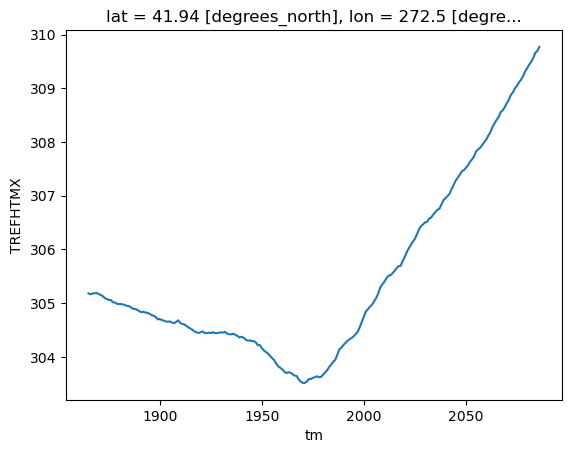

In [33]:
tgmw_mroll0.sel(lat=LAT,lon=LON,method='nearest').sel(quantile=0.71).plot()

In [34]:
# #Add a dummy time dimension to tgnw after relabeling time as 'old_time'
#tgnw = tgnw.rename({'time':'old_time'})
tgnw       = tgnw.chunk({'lat':40,'lon':60})
tgnw_stack = tgnw.stack(mtime=('member','time'),create_index=False)
tgnw_stack = tgnw_stack.expand_dims(dim={'tm':222}).\
               assign_coords(tm=('tm',np.arange(1865,2087)))
tgnw_stack

,Array,Chunk
Bytes,137.19 GiB,60.97 MiB
Shape,"(222, 192, 288, 3000)","(222, 40, 60, 30)"
Count,33701 Tasks,2500 Chunks
Type,float32,numpy.ndarray


In [35]:
tgmc         = (tgnw_stack - tgnw_stack.mean(dim='mtime'))+tgmw_mroll
tgmsc        = (tgnw_stack - tgnw_stack.mean(dim='mtime'))*(tgmw_sroll/tgnw_stack.std(dim='mtime'))\
                + tgmw_mroll
tgmc         = tgmc.chunk({'tm':30,'mtime':3000})
tgmsc        = tgmsc.chunk({'tm':30,'mtime':3000})
tgnw_stack   = tgnw_stack.chunk({'tm':30,'mtime':3000})

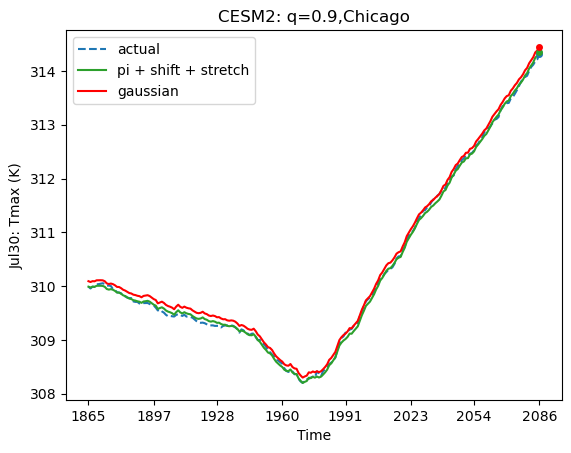

CPU times: user 692 ms, sys: 34.6 ms, total: 727 ms
Wall time: 3.16 s


In [41]:
%%time
#Check if the results are reproduced for Bengaluru
year      = np.arange(1865,2087)
qmw       = qgmw.sel(lat=LAT,lon=LON,method='nearest')
qnw       = qgnw.sel(lat=LAT,lon=LON,method='nearest')
qmc       = qgmc.sel(lat=LAT,lon=LON,method='nearest')
qmsc      = qgmsc.sel(lat=LAT,lon=LON,method='nearest')
qgauss    = qgauss_mw.sel(lat=LAT,lon=LON,method='nearest')

plt.plot(year,qmw.sel(quantile=0.9),'--',color='tab:blue',label='actual')
plt.plot(year,qmsc.sel(quantile=0.9),color='tab:green',label='pi + shift + stretch')
plt.plot(year,qgauss.sel(quantile=0.9),color='red',label='gaussian')
# plt.plot(year,qnw.sel(quantile=0.9),color='tab:blue',label='pi')
# plt.plot(year,qmc.sel(quantile=0.9),color='tab:orange',label='pi + shift')
#########
plt.plot(2086,qmw.sel(quantile=0.9,tm=2086),marker='o',markerfacecolor='tab:blue',\
         markeredgecolor='tab:blue', lw=2, ms=3, mew=2, color='tab:blue')

plt.plot(2086,qmsc.sel(quantile=0.9,tm=2086),marker='o',markerfacecolor='tab:green',\
         markeredgecolor='tab:green', lw=2, ms=3, mew=2, color='tab:green')

plt.plot(2086,qgauss.sel(quantile=0.9,tm=2086),marker='o',markerfacecolor='red',\
         markeredgecolor='red', lw=2, ms=3, mew=2, color='red')

# plt.plot(2086,qnw.sel(quantile=0.9,tm=2086),marker='o',markerfacecolor='tab:blue',\
         # markeredgecolor='tab:blue', lw=2, ms=3, mew=2, color='tab:blue')

# plt.plot(2086,qmc.sel(quantile=0.9,tm=2086),marker='o',markerfacecolor='tab:orange',\
         # markeredgecolor='tab:orange', lw=2, ms=3, mew=2, color='tab:orange')


plt.legend(loc='upper left')
plt.title('CESM2: q=0.9,' +locn)
plt.ylabel(date+': Tmax (K)')
plt.xlabel('Time')
#plt.xlim(1864,2087)
plt.xticks(np.round(np.linspace(1865,2086,8,endpoint=True),0))
plt.show()

In [42]:
%%time
tgmw_min = tgmw_construct_nandrop.min('index')
tgmw_max = tgmw_construct_nandrop.max('index')
tmw_min  = tgmw_min.sel(lat=LAT,lon=LON,method='nearest')
tmw_max  = tgmw_max.sel(lat=LAT,lon=LON,method='nearest')

CPU times: user 12.5 ms, sys: 19 µs, total: 12.5 ms
Wall time: 12 ms


In [45]:
%%time
qgmw_diff   =  qgmw.sel(tm=1865) - qgmw.sel(tm=2086) 
qgmc_diff   =  qgmc.sel(tm=1865) - qgmc.sel(tm=2086)
qgmsc_diff  =  qgmsc.sel(tm=1865)- qgmsc.sel(tm=2086)
qgauss_diff =  qgauss_mw.sel(tm=1865) - qgauss_mw.sel(tm=2086)

CPU times: user 515 ms, sys: 28.7 ms, total: 544 ms
Wall time: 2.98 s


In [46]:
###### Error in prediction for EOC #######
qgmsc_err  = qgmsc.sel(tm=2086)     - qgmw.sel(tm=2086)
qgauss_err = qgauss_mw.sel(tm=2086) - qgmw.sel(tm=2086)

In [50]:
qgmw_reldiff1 = qgmw_diff - qgmc_diff
qgmw_reldiff2 = qgmw_diff - qgmsc_diff
qgmw_reldiff3 = qgmw_diff - qgauss_diff

In [52]:
# %%time
# #Understand the ranges of these quantities
# np.min(qgmw_reldiff1.sel(quantile=0.9)).values,np.max(qgmw_reldiff1.sel(quantile=0.9)).values

In [54]:
#Now, let us compute the relative changes 1) qgmw_diff -0 2) qgmw_diff -qgmc_diff 3) qgmw_diff - qgmsc_diff

In [55]:
#Get green, blue, red, and purple colormaps
green_cmap = cm.get_cmap('Greens')
blue_cmap = cm.get_cmap('RdBu_r')
red_cmap = cm.get_cmap('RdBu_r')
darkred_cmap = cm.get_cmap('spring')


# Create a list of 42 colors
colors = []

# Add 4 decreasing shades of green
green_range = np.linspace(1, 0.5, 4)
for i in green_range:
    colors.append(green_cmap(i))

# Add 16 decreasing shades of blue from RdBu
blue_range = np.linspace(0, 0.5, 16)
for i in blue_range:
    colors.append(blue_cmap(i))

# Add white color
colors.append((1, 1, 1, 1))

# Add 16 shades of red from RdBu
red_range = np.linspace(0.5, 1, 16)
for i in red_range:
    colors.append(red_cmap(i))

# Add 6 shades of dark_red
darkred_range = np.linspace(0.5, 1, 5)
for i in darkred_range:
    colors.append(darkred_cmap(i))

In [56]:
len(colors)

42

In [57]:
levs     = np.concatenate([altspace(-19.0,3.0,4),\
                           altspace(-4.0,0.25,32),altspace(4,3,6)])
levs

array([-19.  , -16.  , -13.  , -10.  ,  -4.  ,  -3.75,  -3.5 ,  -3.25,
        -3.  ,  -2.75,  -2.5 ,  -2.25,  -2.  ,  -1.75,  -1.5 ,  -1.25,
        -1.  ,  -0.75,  -0.5 ,  -0.25,   0.  ,   0.25,   0.5 ,   0.75,
         1.  ,   1.25,   1.5 ,   1.75,   2.  ,   2.25,   2.5 ,   2.75,
         3.  ,   3.25,   3.5 ,   3.75,   4.  ,   7.  ,  10.  ,  13.  ,
        16.  ,  19.  ])

(0.0, 0.0, 1.0)


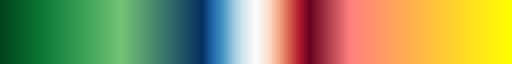

In [58]:
bu_color = mcolors.to_rgb('b')
rd_color = mcolors.to_rgb('r')
print(bu_color)
################################
norm = mcolors.Normalize(-19,19)
# colors = [[norm(-19.0), "#76d154"],
#           [norm(-6.0), '#1fa187'],
#           [norm(-4.0),'royalblue'],
#           [norm( 0), "white"],
#           [norm( 4.0), rd_color],
#           [norm(19.0), 'purple']]
####################
colors0  = list(zip(norm(levs),colors))

cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", colors0)
cmap

In [59]:
#qgmw_diff.sel(quantile=0.9).sel(lat=chic_lat,lon=chic_lon,method='nearest')

In [60]:
ticks    = np.concatenate([altspace(-19.0,3.0,6), altspace(-2.0,2,3),altspace(4,3,6)])
ticks

array([-19., -16., -13., -10.,  -7.,  -4.,  -2.,   0.,   2.,   4.,   7.,
        10.,  13.,  16.,  19.])

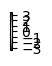

In [64]:
######## New colorbar only for shift + stretch and gaussian ############
x = 3.5
# create a figure and axis
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
# Define colormap
cmap = plt.get_cmap('RdBu_r')
# Make a norm object with the center at 0: TwoSlopeNorm
norm = mcolors.TwoSlopeNorm(vmin=-x, vcenter=0, vmax=x)
# Making numpy array from -3 to 3, with step 0.2
values = np.arange(-x, x+0.25, 0.25)
# Creating a mappable object and setting the norm and cmap for colorbar
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
# Creating a colorbar
ticks1 = altspace(-4,1,9)
cbar = plt.colorbar(mappable, ax=ax, orientation='vertical',ticks=ticks1)
cbar.set_label('')
plt.gca().set_visible(False)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

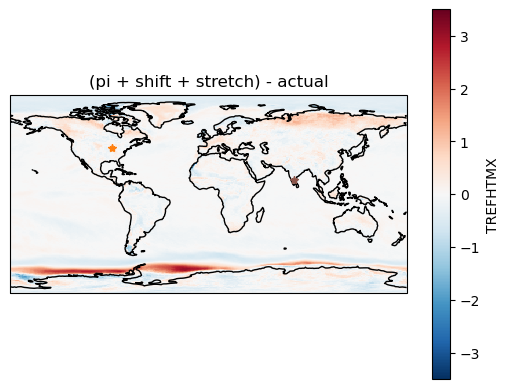

CPU times: user 3.22 s, sys: 142 ms, total: 3.37 s
Wall time: 4.11 s


In [66]:
%%time
#PLot 3c
levels        = np.arange(-3.25,3.75,0.25)
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgmsc_err.sel(quantile=0.9).plot(ax=ax,transform=cart.crs.PlateCarree(),cmap=cmap,norm=norm)
                                      #,add_colorbar=False)
                                     #cbar_kwargs={'ticks': ticks})
ax.coastlines(color="black")
#plt.title('q=0.9,'+r'$\delta t_w - \delta t_{msc}$')
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('(pi + shift + stretch) - actual')
#plt.title('')
plt.show()

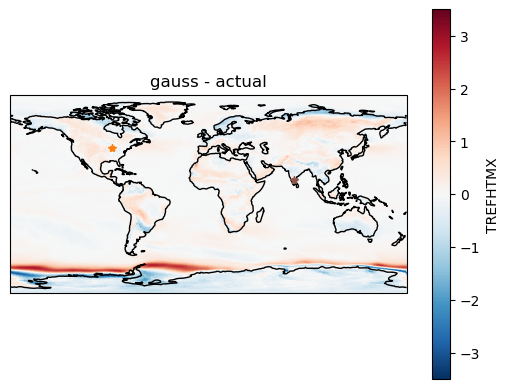

CPU times: user 3.1 s, sys: 116 ms, total: 3.22 s
Wall time: 4.36 s


In [68]:
%%time
#PLot 3d
ax            = plt.axes(projection=cart.crs.PlateCarree())
qgauss_err.sel(quantile=0.9).plot(ax=ax,transform=cart.crs.PlateCarree(),cmap=cmap,norm=norm)
                                     #add_colorbar=False)
                                     #cbar_kwargs={'ticks': ticks})
ax.coastlines(color="black")
#plt.title('q=0.9,'+r'$\delta t_w - \delta t_{gauss}$')
plt.plot(-87.629,41.94,marker='*',color='tab:orange')
plt.plot(77.5,12.72,marker='*',color='tab:brown')
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('gauss - actual')
#plt.title('')
plt.show()

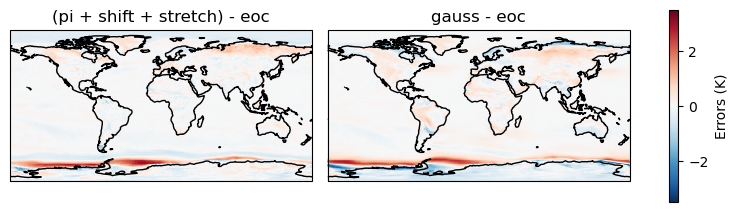

CPU times: user 6 s, sys: 226 ms, total: 6.22 s
Wall time: 11.2 s


In [69]:
%%time
# Creating a figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), subplot_kw={'projection': cart.crs.PlateCarree()}\
                       , gridspec_kw = {'wspace':0.05, 'hspace':0.2})

# Plotting qgmsc_err
qgmsc_err.sel(quantile=0.9).plot(ax=axs[0], transform=cart.crs.PlateCarree(),add_colorbar=False, cmap=cmap, norm=norm)
axs[0].coastlines(color="black")
#axs[0].add_feature(cfeature.BORDERS, linestyle=':')
axs[0].set_title('(pi + shift + stretch) - eoc')

# Plotting da2
im = qgauss_err.sel(quantile=0.9).plot(ax=axs[1], transform=cart.crs.PlateCarree(), add_colorbar=False, cmap=cmap, norm=norm)
axs[1].coastlines(color="black")
#axs[1].add_feature(cfeature.BORDERS, linestyle=':')
axs[1].set_title('gauss - eoc')

# Adding colorbar
cbar = plt.colorbar(im, ax=axs.ravel().tolist(), shrink=0.5, orientation='vertical')
cbar.set_label('Errors (K)')

#plt.tight_layout()
plt.show()

In [70]:
############ Ignore code below this line #####################

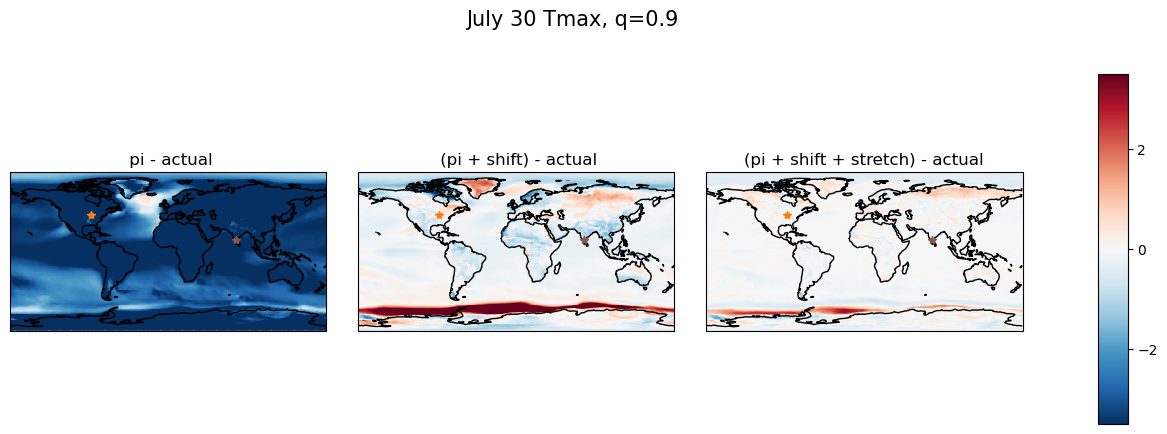

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': cart.crs.PlateCarree()})

data_arrays = [qgmw_diff.sel(quantile=0.9), qgmw_reldiff1.sel(quantile=0.9), qgmw_reldiff2.sel(quantile=0.9)]
titles = [' pi - actual', ' (pi + shift) - actual', '(pi + shift + stretch) - actual']
locations = [(-87.629, 41.94, 'tab:orange'), (77.5, 12.72, 'tab:brown')]

for ax, data, title in zip(axes, data_arrays, titles):
    img = data.plot(ax=ax, transform=cart.crs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
    for loc in locations:
        ax.plot(loc[0], loc[1], marker='*', color=loc[2])
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    ax.coastlines(color="black")
    ax.set_title(title)

# Add a single colorbar
fig.subplots_adjust(right=0.8,wspace=0.1)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(img, cax=cbar_ax, ticks=ticks)
# Add a title to the whole plot
fig.suptitle("July 30 Tmax, q=0.9", fontsize=15)

plt.show()

In [72]:
############# Compute area-weighted mean square of the above errors #####################

In [73]:
qgmw_error_square  = qgmw_diff**2
qgmc_error_square  = qgmw_reldiff1**2
qgmsc_error_square = qgmw_reldiff2**2

In [74]:
weights      = np.cos(np.deg2rad(qgmw_error_square.lat))
weights.name = "weights"
#weights

In [75]:
qgmw_serror_weighted  = qgmw_error_square.weighted(weights)
qgmc_serror_weighted  = qgmc_error_square.weighted(weights)
qgmsc_serror_weighted = qgmsc_error_square.weighted(weights)
qgmc_serror_weighted

DataArrayWeighted with weights along dimensions: lat

In [76]:
%%time
qgmw_serror_gmean   = qgmw_serror_weighted.mean({'lat','lon'})
qgmc_serror_gmean   = qgmc_serror_weighted.mean({'lat','lon'})
qgmsc_serror_gmean  = qgmsc_serror_weighted.mean({'lat','lon'})
qgmc_serror_gmean

CPU times: user 65.5 ms, sys: 2.01 ms, total: 67.5 ms
Wall time: 66 ms


<xarray.DataArray 'TREFHTMX' (quantile: 101)>
dask.array<truediv, shape=(101,), dtype=float64, chunksize=(101,), chunktype=numpy.ndarray>
Coordinates:
    member    int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [77]:
%%time
#p= percentile
qgmw_gmeanpath  = cvals+'qgmw_pserror_gmean'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_gmeanpath  = cvals+'qgmc_pserror_gmean'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmsc_gmeanpath = cvals+'qgmsc_pserror_gmean'+date+'_'+pi_year0+'_'+ic_year1+'.zarr'
# qgmw_serror_gmean.to_dataset().to_zarr(qgmw_gmeanpath,mode='w')
# qgmc_serror_gmean.to_dataset().to_zarr(qgmc_gmeanpath,mode='w')
# qgmsc_serror_gmean.to_dataset().to_zarr(qgmsc_gmeanpath,mode='w')

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 11.4 µs


In [78]:
qgmc_serror_gmean.values

array([5.4520113 , 2.83248084, 2.41191747, 2.14881595, 1.94811829,
       1.78813925, 1.6522887 , 1.53488909, 1.42898315, 1.33472596,
       1.24982379, 1.17103171, 1.09690394, 1.02845755, 0.96352008,
       0.90361556, 0.84689488, 0.79355467, 0.74338831, 0.69597165,
       0.65073172, 0.60803263, 0.56668502, 0.52699936, 0.48947562,
       0.45419587, 0.42106654, 0.38968111, 0.36010594, 0.33261597,
       0.30697244, 0.28302362, 0.26054748, 0.23984582, 0.22055683,
       0.20262713, 0.18632743, 0.17139771, 0.15861396, 0.14672292,
       0.13625106, 0.12707645, 0.11931149, 0.11291956, 0.10763979,
       0.10381098, 0.10095588, 0.09940602, 0.09886693, 0.09946794,
       0.10116583, 0.10406487, 0.10792799, 0.11267936, 0.11852483,
       0.12545016, 0.13331065, 0.14220919, 0.15198079, 0.16278136,
       0.174509  , 0.18694985, 0.20035164, 0.2147024 , 0.23020276,
       0.24632913, 0.26351661, 0.28163855, 0.30059471, 0.32036856,
       0.34144838, 0.36331522, 0.38595891, 0.4097664 , 0.43452

In [79]:
%%time
qgmw_serror_gmean  = xr.open_zarr(qgmw_gmeanpath)
qgmc_serror_gmean  = xr.open_zarr(qgmc_gmeanpath)
qgmsc_serror_gmean = xr.open_zarr(qgmsc_gmeanpath)
qgmw_serror_gmean  = qgmw_serror_gmean.TREFHTMX
qgmc_serror_gmean  = qgmc_serror_gmean.TREFHTMX
qgmsc_serror_gmean = qgmsc_serror_gmean.TREFHTMX
qgmw_grmse         = np.sqrt(qgmw_serror_gmean)
qgmc_grmse         = np.sqrt(qgmc_serror_gmean)
qgmsc_grmse        = np.sqrt(qgmsc_serror_gmean)

CPU times: user 43.7 ms, sys: 4.31 ms, total: 48 ms
Wall time: 211 ms


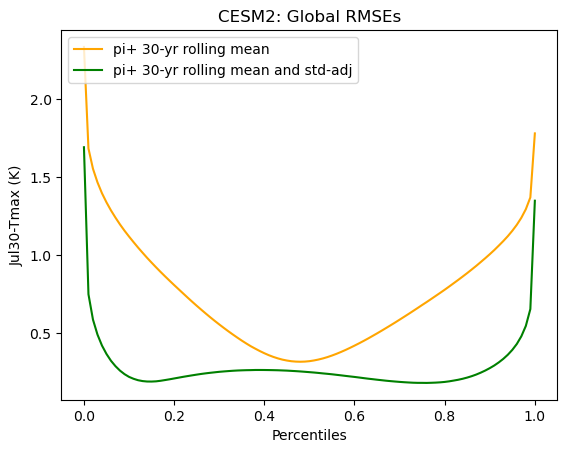

CPU times: user 185 ms, sys: 12 ms, total: 197 ms
Wall time: 316 ms


In [80]:
%%time
#plt.plot(quants,qgmw_serror_gmean,label='warm:30-yr rolling quantile;'+pi_year0+'-'+ic_year1)
plt.plot(quants,qgmc_grmse,label='pi+ 30-yr rolling mean',c='orange')
plt.plot(quants,qgmsc_grmse,label='pi+ 30-yr rolling mean and std-adj',c='g')
plt.legend(loc='upper left')
plt.title('CESM2: Global RMSEs')
plt.ylabel(date+'-Tmax (K)')
plt.xlabel('Percentiles')
# plt.xlim([0, max(x)+1])
# plt.ylim([0, max(y)+1])
plt.show()

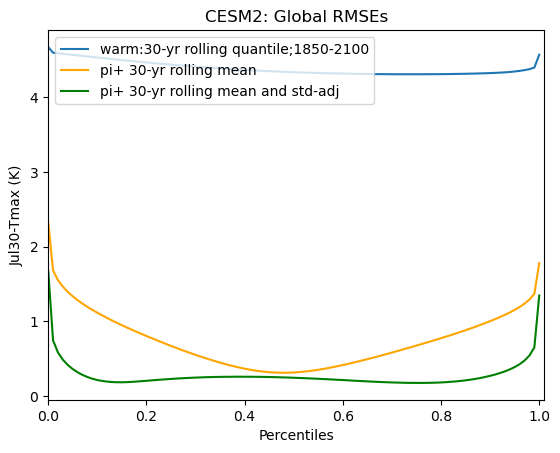

CPU times: user 218 ms, sys: 21.2 ms, total: 239 ms
Wall time: 368 ms


In [81]:
%%time
plt.plot(quants,qgmw_grmse,label='warm:30-yr rolling quantile;'+pi_year0+'-'+ic_year1)
plt.plot(quants,qgmc_grmse,label='pi+ 30-yr rolling mean',c='orange')
plt.plot(quants,qgmsc_grmse,label='pi+ 30-yr rolling mean and std-adj',c='g')
plt.legend(loc='upper left')
plt.title('CESM2: Global RMSEs')
plt.ylabel(date+'-Tmax (K)')
plt.xlabel('Percentiles')
plt.xlim([0.0, np.max(quants)+.01])
#plt.ylim([0.0, np.max(y)+1])
plt.show()